Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Saving Plate_1711623405530_1711623405684.jpeg to Plate_1711623405530_1711623405684.jpeg
Detected Number Plate Text: ~TN87 (5106


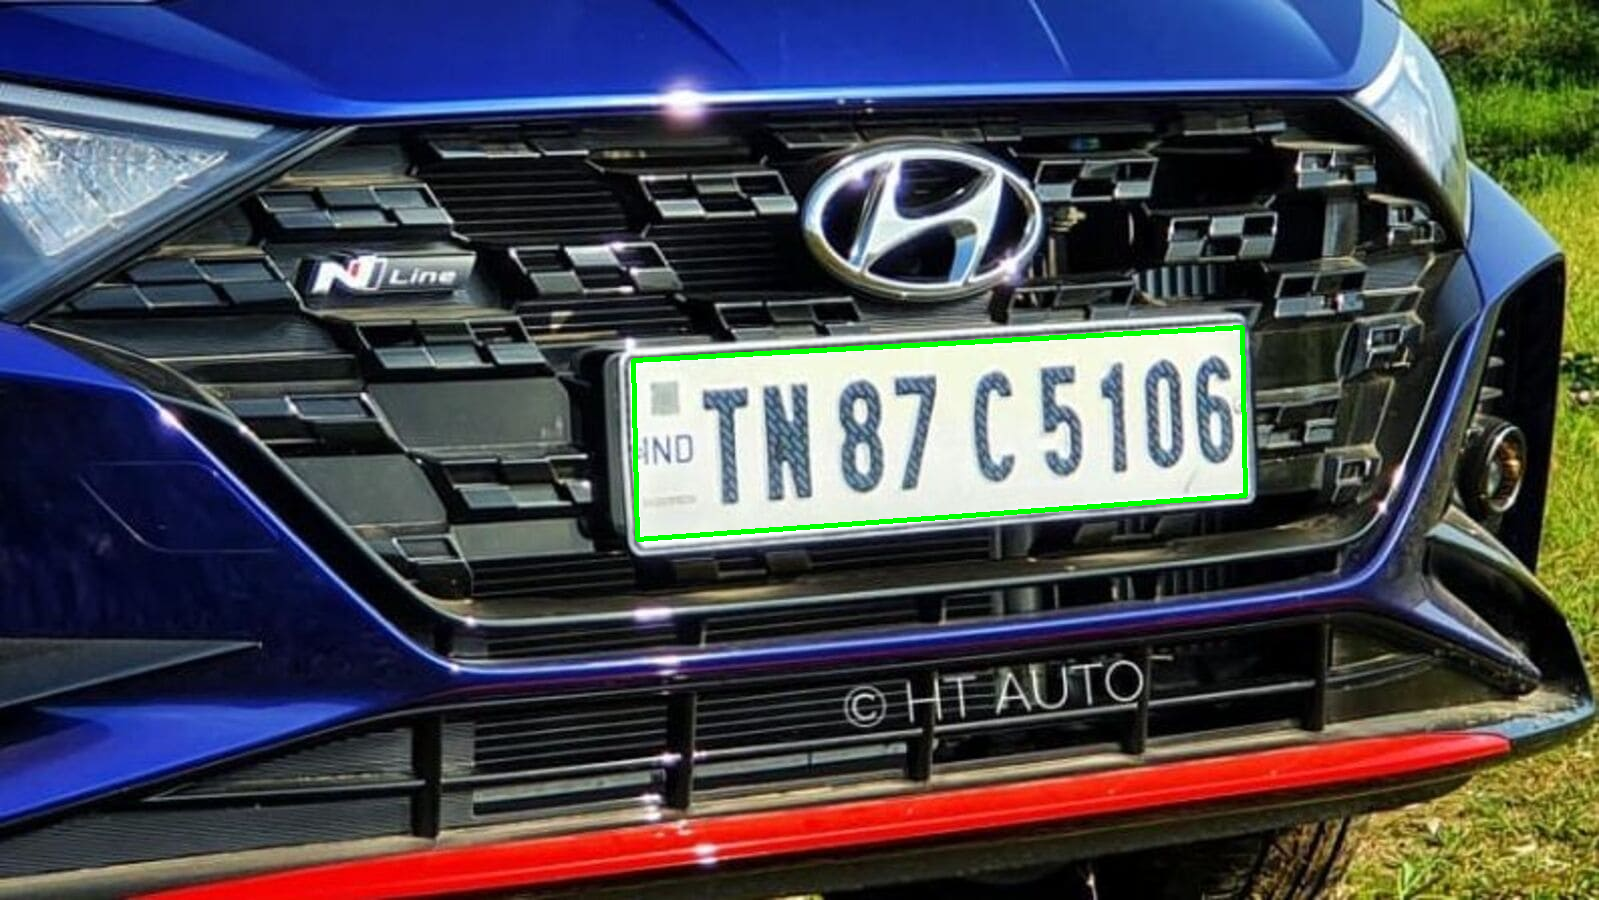

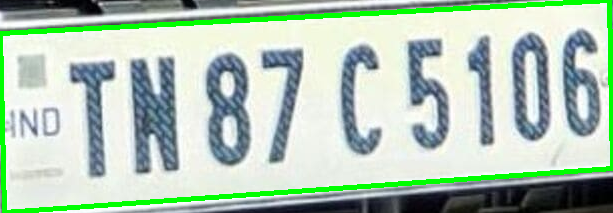

In [7]:
# ✅ Step 1: Install Dependencies
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python

# ✅ Step 2: Import Libraries
import cv2
import pytesseract
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

# ✅ Step 3: OCR Setup
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# ✅ Step 4: Upload Image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ✅ Step 5: Define Functions
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(filtered, 30, 200)
    return edged

def find_plate_contour(edged_image):
    contours, _ = cv2.findContours(edged_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * peri, True)
        if len(approx) == 4:
            return approx
    return None

def extract_plate(image, contour):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y+h, x:x+w]
    return plate_image

def recognize_plate_text(plate_image):
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    text = pytesseract.image_to_string(thresh, config='--psm 8')
    return text.strip()

# ✅ Step 6: Load and Process Image
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found.")
else:
    edged = preprocess_image(image)
    plate_contour = find_plate_contour(edged)

    if plate_contour is not None:
        plate_image = extract_plate(image, plate_contour)
        detected_text = recognize_plate_text(plate_image)

        print("Detected Number Plate Text:", detected_text)
        cv2.drawContours(image, [plate_contour], -1, (0, 255, 0), 3)
        cv2_imshow(image)
        cv2_imshow(plate_image)
    else:
        print("Number plate not detected.")
